In [1]:
from tqdm import tqdm, tnrange, tqdm_notebook
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import pickle
import json

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## Load embeddings

In [ ]:
# from implicit.als import AlternatingLeastSquares

In [ ]:
import h5py

In [ ]:
h5f = h5py.File('/content/drive/MyDrive/lastfm_factors.h5', 'r')
item_factors = h5f['items'][:]
user_factors = h5f['users'][:]
h5f.close()

In [ ]:

class ALS:
  def __init__(self):
    # self.item_factors = np.random.randn(500000, 75)
    # self.user_factors = np.random.randn(686610, 75)
    self.item_factors = item_factors
    self.user_factors = user_factors

als = ALS()

# Neibours search with Faiss

In [ ]:
als.item_factors.shape

(292385, 128)

In [ ]:
als.user_factors.shape

(358868, 128)

# Faiss

In [ ]:
! pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 31.3 MB/s eta 0:00:00


In [ ]:
import faiss

In [ ]:
%%time
ip_index = faiss.IndexFlatIP(als.item_factors.shape[1]) # Create index Exact Search for Inner Product

ip_index.add(als.item_factors) # Add document embeddings to index
print(ip_index.ntotal)

292385
CPU times: user 50.6 ms, sys: 129 ms, total: 180 ms
Wall time: 154 ms


In [ ]:
k = 10  # Choose  10 nearest neighbours
n_users = 1000  # 1000 users is real example of request batch

user_embeddings = als.user_factors[:n_users]

In [ ]:
%%timeit
D, I = ip_index.search(user_embeddings, k)

2.79 s ± 1.36 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
D, I = ip_index.search(user_embeddings, k)

In [ ]:
I

array([[150177, 161850, 107119, ...,  46258, 136336, 259874],
       [186566,  86649,  71465, ..., 252956, 250342, 267949],
       [180940, 142885, 120981, ..., 234769, 241312, 186835],
       ...,
       [252512,  73871, 168195, ...,  86649, 117134, 194180],
       [109930, 141240,   1560, ...,  33602, 129520, 237577],
       [ 21090,  69978,  82825, ..., 208398,  22505, 158209]])

In [ ]:
D

array([[1.1410543 , 1.1322321 , 1.1187365 , ..., 1.0320057 , 1.0301973 ,
        1.0179089 ],
       [1.2508918 , 1.249527  , 1.2257144 , ..., 1.1644775 , 1.1519464 ,
        1.1518093 ],
       [1.2452835 , 1.1997979 , 1.1582257 , ..., 1.1171805 , 1.1170992 ,
        1.1122485 ],
       ...,
       [1.2237133 , 1.0526612 , 0.99917495, ..., 0.932238  , 0.91025347,
        0.90891665],
       [1.0920773 , 1.0610857 , 1.0202018 , ..., 0.95341027, 0.93552566,
        0.9275902 ],
       [0.93441296, 0.88703007, 0.87762   , ..., 0.840016  , 0.8347395 ,
        0.8100572 ]], dtype=float32)

In [ ]:
%%time
product = user_embeddings.dot(als.item_factors.T)
exact_result = np.argsort(product, axis=1)[:,:-k-1:-1]

CPU times: user 37.2 s, sys: 1.23 s, total: 38.4 s
Wall time: 37.4 s


In [ ]:
np.equal(I, exact_result).mean()

1.0

## HNSW

In [ ]:
%%time
neighbours = 48
hnsw_index = faiss.IndexHNSWFlat(als.item_factors.shape[1], neighbours, faiss.METRIC_INNER_PRODUCT) # Create HNSW index

hnsw_index.add(als.item_factors) # Add document embeddings to index
print(hnsw_index.ntotal)

292385
CPU times: user 36min 58s, sys: 2.37 s, total: 37min
Wall time: 21min 39s


In [ ]:
%%time
D, I = hnsw_index.search(user_embeddings, k)

CPU times: user 149 ms, sys: 976 µs, total: 150 ms
Wall time: 102 ms


In [ ]:
I

array([[116468, 247960,  29633, ..., 148045, 106840, 156851],
       [235136,  43089, 217901, ...,  73871, 194180,  42625],
       [167270, 146059,  73686, ..., 102201, 279550, 228200],
       ...,
       [252512,  73871, 212514, ..., 217901, 202346, 264748],
       [212985, 261239, 247960, ...,  30308, 220146, 118839],
       [171553, 142638, 267015, ..., 273645, 203551, 175981]])

In [ ]:
D

array([[0.6581192 , 0.5910607 , 0.5873214 , ..., 0.3925904 , 0.38709292,
        0.37926567],
       [1.0613976 , 0.93626356, 0.8848993 , ..., 0.70074993, 0.6350257 ,
        0.6140816 ],
       [1.0881503 , 1.022892  , 0.96224904, ..., 0.6398827 , 0.63308525,
        0.5922203 ],
       ...,
       [1.2237133 , 1.0526614 , 0.9594545 , ..., 0.87631214, 0.83024466,
        0.76016325],
       [0.88827986, 0.7469681 , 0.74616563, ..., 0.5229465 , 0.50319237,
        0.4639511 ],
       [0.7846954 , 0.63894916, 0.61645097, ..., 0.4503438 , 0.42328727,
        0.4055509 ]], dtype=float32)

In [ ]:
exact_result

array([[150177, 161850, 107119, ...,  46258, 136336, 259874],
       [186566,  86649,  71465, ..., 252956, 250342, 267949],
       [180940, 142885, 120981, ..., 234769, 241312, 186835],
       ...,
       [252512,  73871, 168195, ...,  86649, 117134, 194180],
       [109930, 141240,   1560, ...,  33602, 129520, 237577],
       [ 21090,  69978,  82825, ..., 208398,  22505, 158209]])

In [ ]:
np.equal(I, exact_result).mean()

0.0093

Algorithm is not tuned for the dataset, so results are poor. But you can find optimal parameters for 99% or even 99.9%.

# Quantization

In [ ]:
als.item_factors[:, 0]

array([-0.5070323 , -0.22206925,  0.07786673, ..., -0.00242566,
        0.00070037,  0.00093981], dtype=float32)

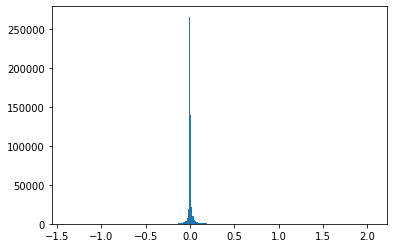

In [ ]:
_ = plt.hist(als.item_factors[:, 0], bins=255)

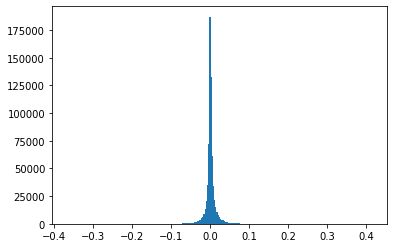

In [ ]:
_ = plt.hist(als.user_factors[:, 0], bins=255)

# Percentile quantization (items)

In [ ]:
N = 100000

In [ ]:
percentiles = []
for perc in tqdm_notebook(np.linspace(0, 100, 256)):
    percentiles.append(np.percentile(als.item_factors[:N, :], perc, axis=0))

<ipython-input-43-0be72a99dcd8>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for perc in tqdm_notebook(np.linspace(0, 100, 256)):


  0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
percentiles = np.vstack(percentiles)

In [ ]:
def quantize(v):
    res = []
    for i in range(v.shape[1]):
        res.append(np.digitize(v[:, i], percentiles[:, i]))
    res = np.vstack(res).T
    res = np.clip(res, 0, 255)
    return res

In [ ]:
def restore(q):
    res = []
    for i in range(q.shape[1]):
        res.append(percentiles[q[:, i], i])
    return np.vstack(res).T

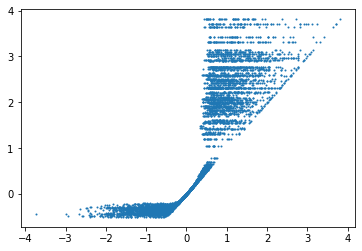

In [ ]:
plt.scatter(als.item_factors[0:100, :], restore(quantize(als.item_factors[0:100, :])), s=1)

In [ ]:
list(zip(
    als.item_factors[:1].ravel(),
    restore(quantize(als.item_factors[:1])).ravel()
))[::10]

[(-0.5070323, -0.28041169783648323),
 (-0.17353138, -0.1641087451401879),
 (-2.115754, -0.44444459711804113),
 (0.3447493, 0.44090349884594376),
 (0.71502763, 1.807509422302246),
 (0.2777188, 0.2945785845027263),
 (0.9828511, 2.9209845066070557),
 (2.8066685, 3.131331443786621)]

In [ ]:
overlaps = []
boo = restore(quantize(als.item_factors[:N]))
for user_idx in range(1, N, int(N / 100)):
    scores1 = als.item_factors[:N].dot(als.user_factors[user_idx, :])
    scores2 = boo.dot(als.user_factors[user_idx, :])
    order1 = np.argsort(scores1)[::-1][:100]
    order2 = np.argsort(scores2)[::-1][:100]
    overlaps.append(len(set(order1) & set(order2)))
print ("MEAN:", np.mean(overlaps))

MEAN: 68.5


# Percentile quantization (users)

In [ ]:
percentiles = []
for perc in tqdm_notebook(np.linspace(0, 100, 256)):
    percentiles.append(np.percentile(als.user_factors[:N, :], perc, axis=0))

<ipython-input-52-076bce87f130>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for perc in tqdm_notebook(np.linspace(0, 100, 256)):


  0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
percentiles = np.vstack(percentiles)

In [ ]:
def quantize(v):
    res = []
    for i in range(v.shape[1]):
        res.append(np.digitize(v[:, i], percentiles[:, i]))
    res = np.vstack(res).T
    res = np.clip(res, 0, 255)
    return res

In [ ]:
def restore(q):
    res = []
    for i in range(q.shape[1]):
        res.append(percentiles[q[:, i], i])
    return np.vstack(res).T

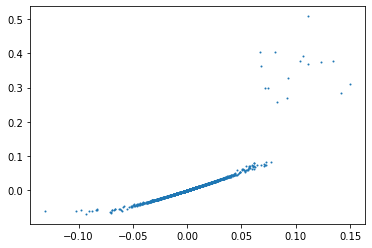

In [ ]:
plt.scatter(als.user_factors[0:100, :], restore(quantize(als.user_factors[0:100, :])), s=1)

In [ ]:
list(zip(
    als.user_factors[:1].ravel(),
    restore(quantize(als.user_factors[:1])).ravel()
))[::10]

[(-0.0002565098, -0.00023197876392206236),
 (0.0005038537, 0.0005104812759193865),
 (-0.0007521588, -0.0007425793076810591),
 (0.00065790216, 0.0006657454938463428),
 (9.878183e-06, 1.0468788679966435e-05),
 (-0.0008532091, -0.0008440442314809741),
 (0.0006059257, 0.0006369008449837558),
 (0.0005596848, 0.0005831072750665681)]

In [ ]:
overlaps = []
for user_idx in range(1, N, int(N/100)):
    scores1 = als.item_factors[:N].dot(als.user_factors[user_idx, :])
    scores2 = als.item_factors[:N].dot(restore(quantize(als.user_factors[user_idx:user_idx+1, :]))[0])
    order1 = np.argsort(scores1)[::-1][:100]
    order2 = np.argsort(scores2)[::-1][:100]
    overlaps.append(len(set(order1) & set(order2)))
print("MEAN:", np.mean(overlaps))

MEAN: 96.57


# MinMax quantization (items)

In [ ]:
l = np.percentile(als.item_factors[:N], 1, axis=0)
h = np.percentile(als.item_factors[:N], 99, axis=0)

In [ ]:
def quantize(v):
    return (np.minimum(np.maximum((v - l) / (h - l + 1e-6), 0), 1) * 255).astype(np.uint8)

s = (h - l + 1e-6) / 255.
def restore(q):
    return q.astype(np.float32) * s + l

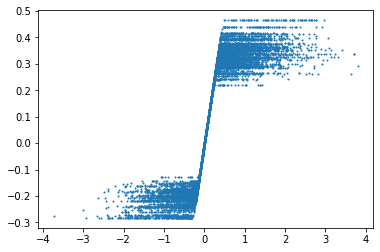

In [ ]:
plt.scatter(als.item_factors[0:100, :], restore(quantize(als.item_factors[0:100, :])), s=1)

In [ ]:
list(zip(
    als.item_factors[:1].ravel(),
    restore(quantize(als.item_factors[:1])).ravel()
))[::10]

[(-0.5070323, -0.19047160908579827),
 (-0.17353138, -0.17475231526126675),
 (-2.115754, -0.27883906751871107),
 (0.3447493, 0.30239499492740624),
 (0.71502763, 0.37517727418041075),
 (0.2777188, 0.27633398919227603),
 (0.9828511, 0.29947421623563697),
 (2.8066685, 0.3250748140940661)]

In [ ]:
overlaps = []
boo = restore(quantize(als.item_factors[:N]))
for user_idx in range(1, N, int(N / 100)):
    scores1 = als.item_factors[:N].dot(als.user_factors[user_idx, :])
    scores2 = boo.dot(als.user_factors[user_idx, :])
    order1 = np.argsort(scores1)[::-1][:100]
    order2 = np.argsort(scores2)[::-1][:100]
    overlaps.append(len(set(order1) & set(order2)))
print("MEAN:", np.mean(overlaps)  )

MEAN: 61.83


# MinMax quantization (users)

In [ ]:
l = np.percentile(als.user_factors[:N], 1, axis=0)
h = np.percentile(als.user_factors[:N], 99, axis=0)

In [ ]:
def quantize(v):
    return (np.minimum(np.maximum((v - l) / (h - l + 1e-6), 0), 1) * 255).astype(np.uint8)

s = (h - l + 1e-6) / 255.
def restore(q):
    return q.astype(np.float32) * s + l

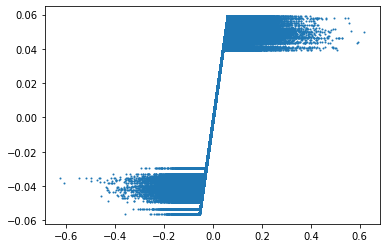

In [ ]:
plt.scatter(als.user_factors, restore(quantize(als.user_factors)), s=1)

In [ ]:
list(zip(
    als.user_factors[:1].ravel(),
    restore(quantize(als.user_factors[:1])).ravel()
))[::10]

[(-0.0002565098, -0.0006066543369027538),
 (0.0005038537, 0.00047445159565068923),
 (-0.0007521588, -0.000791168151171584),
 (0.00065790216, 0.0004096150351130465),
 (9.878183e-06, -0.0003281212743885542),
 (-0.0008532091, -0.0011354307749033704),
 (0.0006059257, 0.00029786160046654103),
 (0.0005596848, 0.00021612489267533452)]

In [ ]:
overlaps = []
for user_idx in range(1, N, int(N/100)):
    scores1 = als.item_factors[:N].dot(als.user_factors[user_idx, :])
    scores2 = als.item_factors[:N].dot(restore(quantize(als.user_factors[user_idx:user_idx+1, :]))[0])
    order1 = np.argsort(scores1)[::-1][:100]
    order2 = np.argsort(scores2)[::-1][:100]
    overlaps.append(len(set(order1) & set(order2)))
print( "MEAN:", np.mean(overlaps))

MEAN: 96.57
